Rugby union is one of the most popular sports worldwide, yet very little public data exists for the game. Its Rugby is an excellent site that collects data from global rugby competitions and puts it into a readable format for fans everywhere. Here I scrape relevant data from this website and use it to analyze various aspects of the game. To accomplish this, I develop a support vector classification model to predict whether a player changing leagues will experience an increase in playing time. I use this model to rank the approximate strength of nine of the top international club competitions. This work only scratches the surface of what can be done with rugby data and what can be done with this dataset.  Below is the code I used to scrape the data from the site and the analysis I performed.

In [141]:
#Import modules needed for web scraping
import requests
import lxml.html as lh
import numpy as np
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import pandas as pd
import re
from datetime import datetime

These functions are used to scrape the data on the webpage. The function league_stats iterates through the links on the archive page and then through each year of data. Every year of league data has a table with that season's stats which are saved by the function league_year_stats. This collects the totals and game averages of tries, penalty goals, conversion kicks, and drop goals.

## League Data

In [142]:
#Function only returns data for the top league from region (As decided by itsrugby.com)
def league_year_stats(soup):
    count = 0
    result_array = []

    for result in soup.find_all('tr'):
        for result2 in result.find_all('td', attrs = {"align": "center", "id": "noir"}):
            if (count>7 and count <32):
                try:
                    result_array.append(float(result2.contents[0]))
                except: 
                    result_array.append(np.nan)
            count+=1
    return(result_array)
def league_stats(region_key, league_str):
    URL = 'https://www.itsrugby.co.uk/' + region_key + '.html'
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    url_tails = []
    url_head = 'https://www.itsrugby.co.uk/'
    league_stats_dict = {'league': [], 'year': [], 'tries_avg': [], 'tries_nb': [], 'conv_avg': [], 'conv_nb': [], 'pen_avg': [], 'pen_nb': [], 'dg_avg': [], 'dg_nb': []}
    result_ind = [0,0, 1,0,7,6,13,12,19,18]
    for a_href in soup.find_all('a', href=True):
        if (str(a_href['href'])[0:7] == 'result-'):
            url_tails.append(str(a_href['href'])[6:])
    for i in range(len(url_tails)):
        URL = url_head + 'stats' + url_tails[i]
        page = requests.get(URL)
        soup = BeautifulSoup(page.text, "html.parser")
        year = URL[-9:-5]
        result_array = league_year_stats(soup)
        for k in range(8):
            try:
                league_stats_dict[list(league_stats_dict.keys())[k+2]].append(result_array[result_ind[k+2]])
            except IndexError: 
                league_stats_dict[list(league_stats_dict.keys())[k+2]].append(np.nan)
    
        league_stats_dict['year'].append(float(year))
        league_stats_dict['league'].append(league_str)
    return(pd.DataFrame.from_dict(league_stats_dict))

Using these functions, I collect data on some of the top international competitions. England Premiership, Top 14 (France), and Super Rugby (Australia, Fiji, New Zealand, and the Pacific Islands) are all regular league competitions. The European Rugby Championship Cup (Heineken Cup) is an annual tournament played by European clubs. The 6 Nations Tournament is an annual international competition played by England, Scotland, Ireland, Wales, France, and Italy. These leagues host some of the top union players worldwide and represent a sample of how top-level rugby is played.

In [143]:
ml_leagues = ['englandpremiership', 'top14', 'superrugby', '6nationstournament', 'heinekencup']
archive_links = ['archives-irluk', 'archives-fr', 'archives-hemsud', 'archives-int', 'archives-cupeurope']
league_dataframes = []
for i in range(len(ml_leagues)):
    league_dataframes.append(league_stats(archive_links[i], ml_leagues[i]))
ml_stats_df = pd.concat(league_dataframes, ignore_index=True)
ml_stats_df = ml_stats_df.drop(ml_stats_df[(ml_stats_df.league == 'superrugby') & (ml_stats_df.year == '2019')].index)


In [144]:
#Generate new stats based on available data
ml_stats_df['games'] = ml_stats_df['tries_nb'] / ml_stats_df['tries_avg']
ml_stats_df['conv_rate'] = ml_stats_df['conv_avg'] / ml_stats_df['conv_avg']
ml_stats_df['tcp_avg'] = (ml_stats_df['tries_avg']*5) + (ml_stats_df['conv_avg']*2) + (ml_stats_df['pen_avg']*3)
ml_stats_df['tcp_nb'] = ml_stats_df['tcp_avg'] * ml_stats_df['games']

In [145]:
#Find trends of last 10 years of scoring data
X = np.arange(ml_stats_df['year'].min(), ml_stats_df['year'].max() +1)
y_tries = ml_stats_df.groupby('year').sum()['tries_nb'] / ml_stats_df.groupby('year').sum()['games']
y_pen = ml_stats_df.groupby('year').sum()['pen_nb'] / ml_stats_df.groupby('year').sum()['games']
y_tcp = ml_stats_df.groupby('year').sum()['tcp_nb'] / ml_stats_df.groupby('year').sum()['games']
idx = np.isfinite(X) & np.isfinite(y_tries) & (X >= 2010)
tries_fit = np.polyfit(X[idx], y_tries[idx], 1)
idx = np.isfinite(X) & np.isfinite(y_pen) & (X >= 2010)
pen_fit = np.polyfit(X[idx], y_pen[idx], 1)
idx = np.isfinite(X) & np.isfinite(y_tcp) & (X >= 2010)
tcp_fit = np.polyfit(X[idx], y_tcp[idx], 1)

0.3058513742063408 8.67887002572985
0.4592707816385034 -7.93346178705076
0.07472637075301514 3.4564212654232733
5.758013285573554 3.113526023223301


Text(0.5, 1.0, 'Points from Tries, Conversions, and Penalty Goals per Game Since 2010')

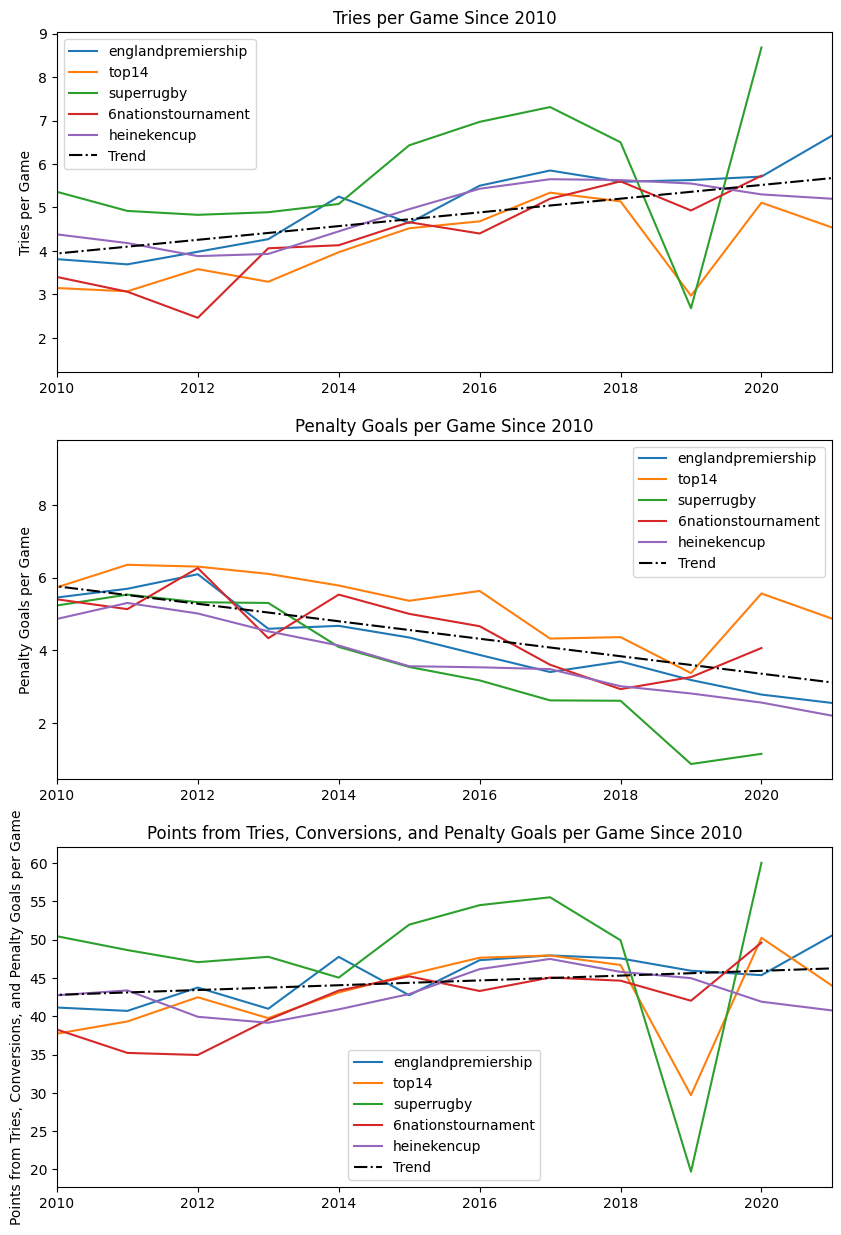

In [150]:
y_tries_fit = X*tries_fit[0] + tries_fit[1]
y_pen_fit = X*pen_fit[0] + pen_fit[1]
y_tcp_fit = X*tcp_fit[0] + tcp_fit[1]
print(((y_tries_fit[-1] - y_tries_fit[15]) / y_tries_fit[-1]), (y_tries_fit[-1] - y_tries_fit[15])*5)
print(((y_pen_fit[15] - y_pen_fit[-1]) / y_pen_fit[15]), (y_pen_fit[-1] - y_pen_fit[15])*3)
print(1-(y_tcp_fit[15] / y_tcp_fit[-1]), y_tcp_fit[-1] - y_tcp_fit[15])
print(y_pen_fit[15], y_pen_fit[-1])


plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
count = 2
for league in ml_leagues:
    plt.plot(ml_stats_df[ml_stats_df['league'] == league]['year'], ml_stats_df[ml_stats_df['league'] == league]['tries_avg'])
plt.plot(X, y_tries_fit, linestyle = '-.', color = 'black')
plt.legend(ml_leagues + list(['Trend']))
plt.xlim([2010, 2021])
plt.ylabel('Tries per Game')
plt.title('Tries per Game Since 2010')

plt.subplot(3,1,2)
count = 2
for league in ml_leagues:
    plt.plot(ml_stats_df[ml_stats_df['league'] == league]['year'], ml_stats_df[ml_stats_df['league'] == league]['pen_avg'])
plt.plot(X, y_pen_fit, linestyle = '-.', color = 'black')
plt.legend(ml_leagues + list(['Trend']))
plt.xlim([2010, 2021])
plt.ylabel('Penalty Goals per Game')
plt.title('Penalty Goals per Game Since 2010')

plt.subplot(3,1,3)
count = 2
for league in ml_leagues:
    plt.plot(ml_stats_df[ml_stats_df['league'] == league]['year'], ml_stats_df[ml_stats_df['league'] == league]['tcp_avg'])
plt.plot(X, y_tcp_fit, linestyle = '-.', color = 'black')
plt.legend(ml_leagues + list(['Trend']))
plt.xlim([2010, 2021])
plt.ylabel('Points from Tries, Conversions, and Penalty Goals per Game')
plt.title('Points from Tries, Conversions, and Penalty Goals per Game Since 2010')


Over the last ten years of top-flight rugby, the sport has seen a sizable shift in scoring approach. Penalty goals are down forty-six percent, but tries have jumped thirty-one percent. This decrease in penalty goals is made up for by the increase in tries as a penalty goal is worth only three points while a try is worth five points plus the opportunity for a two-point conversion. The increase in tries has lead to an overall increase in scoring of 3.5 points per game.

## Player Data

Its Rugby has career data for all active players in leagues for which there is data. Below I scrape this career data from most professional rugby union club competitions. This is achieved by opening each league's player pages and saving all player links. I then use a complex loop to collect data from the player pages. This involves collecting position, name, and birthdate information from the player's bio and all statistical data from each player's stats table. 

In [50]:
leagues = ['top14', 'prod2', 'federale1', 'englandpremiership', 'unitedrugbychampionship', 'englandchampionship', 'superrugby', 'curriecupfirstdiv', 'urbatop13', 'japan', 'majorleaguerugby']
player_links = []
for i in range(len(leagues)):
    URL = 'https://www.itsrugby.co.uk/players/competitions/{}.html#'.format(leagues[i])
    page = requests.get(URL)
    soup = BeautifulSoup(page.text, "html.parser")
    for link in soup.findAll('a'):
        if(str(link.get('href'))[21:28] == 'players'):
            player_links.append(str(link.get('href'))[2:])

In [52]:
fp = open('player_link.txt', 'w')
for link in player_links:
    fp.write('{}\n'.format(link))
fp.close()

The function below takes a link from the list of player links and outputs a DataFrame with all the data from that player's page.

In [9]:
def player_data(URL):
    URL = 'https://' + URL
    page = requests.get(URL)
    #Open player page
    soup = BeautifulSoup(page.text, "html.parser")
    count = 0
    result_array = []
    start = False
    #Dictionary to save data
    stats_dict = {'player_id': [], 'birthdate': [], 'pos': [], 'year': [], 'team': [], 'competition': [], 'pts': [], 'played': [], 'start': [], 'try': [], 'pen': [], 'dp': [], 'tr': [], 'yellow': [], 'red': [], 'min': []}
    #Collect and save player position
    string = str(soup.find_all('span')[1].contents)
    split_string = string.split('xa0')
    pos = split_string[1][:-2]
    
    #Save birthdates from players where it is shared and record nan for those without birthdates
    try:
        string2 = str(soup.find_all('p')[1])
        match = re.search(r'\d{2}/\d{2}/\d{4}', string2)
        bd = match.group(0)
    except:
        bd = np.nan
        
    tr_count = 0
    
    #Loop through each row in the page
    for result in soup.find_all('tr'):
        tr_count += 1
        if((start) & ('tr class=\"itsBlue1\"' in str(result))):
            #Break loop if iterated through the end of the table
            break;
        if((start) & ('style=' in str(result.find_all('td')[0]))):
            #If row is in the same year as before save previous year and adjust column tracker
            stats_dict['year'].append(stats_dict['year'][-1])
            track = 1
        elif((start) & (str(result.find_all('td')[0].contents[0])[0] not in ['0', '1', '2', '9'])):
            #If year and team are same as previous year save previous values and adjust column tracker
            stats_dict['year'].append(stats_dict['year'][-1])
            stats_dict['team'].append(stats_dict['team'][-1])
            track = 4
        else:
            track = -1
            
        keys = list(stats_dict.keys())
        k = 7

        for result2 in result.find_all('td'):
        #Iterate through columns   
            if(start):
                #Update column tracker
                track += 1   
            if(track == 0):
                #For first columns save year
                if(len(str(result2.contents[0])) == 5):
                    stats_dict['year'].append(int('20' + result2.contents[0][:2]))
                else:
                    stats_dict['year'].append(int(str(result2.contents[0])))

            if(track == 2):
                #For second column save team
                a = result2.find('a').contents[0]
                stats_dict['team'].append(a)
                
            if(track == 5):
                #For third column save competition
                stats_dict['competition'].append(result2.contents[0])
                #Because this is the only column each row of each player has this is where we add the player info to the dictionary
                stats_dict['player_id'].append(URL[35:-6])
                stats_dict['pos'].append(pos)
                stats_dict['birthdate'].append(bd)
                
            if(track == 7):
                if(result2.contents[0] == 'No data'):
                    #Check and see if there is stats data. If not save nan
                    for i in range(len(keys[6:])):
                        stats_dict[keys[i+6]].append(np.nan)
                    break;
                else:
                    try:
                        stats_dict['pts'].append(float(result2.contents[0]))
                        #For the fourth column save pts data
                    except:
                        stats_dict['pts'].append(0.0)

            if((track > 7) & (track%2 !=0) & (track != 25)):
                try:
                    #Save data for columns 5 through 12 save relevant stats
                    a = float(result2.find('a').contents[0])
                    stats_dict[keys[k]].append(a)
                except:
                    stats_dict[keys[k]].append(0.0)
                k += 1
        
            if(track == 25):
                #For the final colu save minutes data
                a = result2.contents[0]
                try:
                    stats_dict['min'].append(float(a))
                except:
                    stats_dict['min'].append(0.0)
                    
            if((count == 25) & (~start)):
                #Identify the first row of table, save year, and begin tracking columns
                if(len(str(result2.contents[0])) == 5):
                    stats_dict['year'].append(int('20' + result2.contents[0][:2]))
                else:
                    stats_dict['year'].append(int(str(result2.contents[0])))
                start = True
                track += 1
        
            count += 1
            
    return(pd.DataFrame.from_dict(stats_dict)) 
        

In [2]:
player_links = open('player_link.txt').readlines()

In [ ]:
#Loop through the aboce function for each player link
#Function works for all players with valid pages. 19 links do not have valid pages and are thus skipped
player_dfs = []
bad_players = []
count_success = 0
count_fail = 0
player_links_len = len(player_links)
for i in range(player_links_len):
    try:
        player_dfs.append(player_data(player_links[i][:-1]))
        count_success += 1
    except:
        bad_players.append(player_links[i][:-1])
        count_fail += 1
    if((i%100) == 0):
        print(str((i/player_links_len) * 100) + '%')
        print((count_fail / (count_fail + count_success))*100)

In [11]:
#Combine data into one dataframe
players_df = pd.concat(player_dfs, ignore_index = True)

In [ ]:
#Save dataframe as zipped CSV
compression_opts = dict(method='zip', archive_name='itsrugby_players.csv')
players_df.to_csv('itsrugby_players.zip', index=False, compression=compression_opts)

After iterating through each player and combining each DataFrame, we have a DataFrame with 51211 rows and 16 columns. Each row represents one competition that one player competed in during a single year. Some players have over ten years of data playing in multiple competitions yearly.

In [155]:
players_df = pd.read_csv('itsrugby_players.zip')
players_df

,player_id,birthdate,pos,year,team,competition,pts,played,start,try,pen,dp,tr,yellow,red,min
0,esteban-abadie-4289,01/12/1997,Third Row,2022,Brive,Top 14,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,160.0
1,esteban-abadie-4289,01/12/1997,Third Row,2021,Brive,European Rugby Challenge Cup,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0
2,esteban-abadie-4289,01/12/1997,Third Row,2021,Brive,Top 14,10.0,20.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0,1185.0
3,esteban-abadie-4289,01/12/1997,Third Row,2020,Brive,European Rugby Challenge Cup,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,136.0
4,esteban-abadie-4289,01/12/1997,Third Row,2020,Brive,Top 14,0.0,8.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,315.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51206,juanpablo-zeiss-2326,02/08/1989,Prop,2020,Jaguares XV,Super Liga Americana,10.0,10.0,8.0,2.0,0.0,0.0,0.0,0.0,0.0,480.0
51207,juanpablo-zeiss-2326,02/08/1989,Prop,2019,Ceibos Rugby,Super Liga Americana,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,128.0
51208,juanpablo-zeiss-2326,02/08/1989,Prop,2019,Jaguares,Super Rugby,0.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,178.0
51209,juanpablo-zeiss-2326,02/08/1989,Prop,2018,Jaguares,Super Rugby,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0


## Data Formatting

To get the data ready for analysis and modeling, I need to create new variables and remove erroneous values from the dataframe.

In [156]:
def age(row):
    #Find age of player on July first of league year
    birthdate = str(row['birthdate'])
    ref_year = row['year']
    ref_date =  '07/01/' + str(ref_year)
    ref_date = datetime.strptime(ref_date, '%d/%m/%Y')
    birthdate_strp = datetime.strptime(birthdate, '%d/%m/%Y')
    age = ref_date.year - birthdate_strp.year - ((ref_date.month, ref_date.day) < (birthdate_strp.month, birthdate_strp.day))
    return age

def prev_year_league(row, df):
    #Save league played in the previous year
    player_id = row['player_id']
    year = row['year']
    prev_year = df[(df['year'] - year == -1) & (df['player_id'] == player_id)]
    if(len(prev_year['competition']) > 1):
        prev_league = np.nan
    elif(len(prev_year['competition']) > 0):
        prev_league = np.array(prev_year['competition'])[0]
    else:
        prev_league = np.nan
    return prev_league

def prev_year_min(row, df):
    #Save minutes from previous year
    player_id = row['player_id']
    year = row['year']
    prev_year = df[(df['year'] - year == -1) & (df['player_id'] == player_id)]
    if(len(prev_year['competition']) > 1):
        prev_min = np.nan
    if(len(prev_year['min']) > 0):
        prev_min = np.array(prev_year['min'])[0]
    else:
        prev_min = np.nan
    return prev_min

def prev_year_played(row, df):
    #Save games played from previous year
    player_id = row['player_id']
    year = row['year']
    prev_year = df[(df['year'] - year == -1) & (df['player_id'] == player_id)]
    if(len(prev_year['competition']) > 1):
        prev_played = np.nan
    if(len(prev_year['played']) > 0):
        prev_played = np.array(prev_year['played'])[0]
    else:
        prev_played = np.nan
    return prev_played

def prev_year_start(row, df):
    #Save games started from previous year
    player_id = row['player_id']
    year = row['year']
    prev_year = df[(df['year'] - year == -1) & (df['player_id'] == player_id)]
    if(len(prev_year['competition']) > 1):
        prev_start = np.nan
    if(len(prev_year['start']) > 0):
        prev_start = np.array(prev_year['start'])[0]
    else:
        prev_start = np.nan
    return prev_start

def career_minutes(row, df):
    #Save career minutes up until current season
    player_id = row['player_id']
    year = row['year']
    df_player = df[(df['player_id'] == player_id) & (df['year'] < year)]
    minutes = np.sum(np.array(df_player['min']))
    return minutes
    

def career_played(row, df):
    #Save career played
    player_id = row['player_id']
    year = row['year']
    df_player = df[(df['player_id'] == player_id)& (df['year'] < year)]
    played = np.sum(np.array(df_player['played']))
    return played

def career_start(row, df):
    #Save career starts
    player_id = row['player_id']
    year = row['year']
    df_player = df[(df['player_id'] == player_id)& (df['year'] < year)]
    start = np.sum(np.array(df_player['start']))
    return start


In [157]:
#Drop nan rows
players_df = players_df.dropna(axis=0)
#Run age function
players_df['age'] = players_df.apply(lambda row: age(row), axis=1)
#Drop duplicate rows
players_df = players_df.drop_duplicates()

#Shrink dataset to include only top leagues with lots of player data
leagues = ['Top 14', 'Pro D2', 'PRO 14', 'ITM Cup', 'Super Rugby', 'NPC', 'Rabodirect PRO12', 'National Rugby Championship',  'United rugby championship',  'Air New Zealand Cup', 'MITRE 10 CUP',  'Currie Cup', 'Guinness Premiership', 'England Premiership', 'England Championship',  'Super 10', 'Super 14', 'Provincial Cup', 'England Cup',  'Super 12', 'Top 16',   'Celtic League']
players_df = players_df[players_df.competition.isin(leagues)]
#Fix issues with leagues changing names
league_names = [['Top 14', 'Top 16'], ['United Rugby Championship', 'United rugby championship', 'PRO 14', 'Celtic League', 'Rabodirect PRO12'], ['NPC', 'ITM Cup', 'MITRE 10 CUP', 'Provincial Cup', 'Air New Zealand Cup'],  ['England Premiership', 'Guinness Premiership'], ['Super Rugby', 'Super 12', 'Super 10', 'Super 14'], ['England Championship', 'England Cup']]
for i in range(len(league_names)):
    players_df.loc[players_df['competition'].isin(league_names[i]), ['competition']] = league_names[i][0]
    
total_competitions = players_df['competition'].unique()

/var/folders/7v/_90wc0ds3jd2h03mn95j4sfc0000gn/T/ipykernel_3767/3530866926.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_df['age'] = players_df.apply(lambda row: age(row), axis=1)


In [158]:
#Remove rows with invalid values
players_df = players_df[players_df['min'] > 0]
players_df = players_df[players_df['played'] >0]

#Run earlier functions
players_df['prev_year_competition'] = players_df.apply(lambda row: prev_year_league(row, players_df), axis=1)
players_df['prev_year_min'] = players_df.apply(lambda row: prev_year_min(row, players_df), axis=1)
players_df['prev_year_played'] = players_df.apply(lambda row: prev_year_played(row, players_df), axis=1)
players_df['career_min'] = players_df.apply(lambda row: career_minutes(row, players_df), axis=1)
players_df['career_played'] = players_df.apply(lambda row: career_played(row, players_df), axis=1)
players_df['prev_year_start'] = players_df.apply(lambda row: prev_year_start(row, players_df), axis=1)
players_df['career_start'] = players_df.apply(lambda row: career_start(row, players_df), axis=1)
#Find average values
players_df['min_avg'] = players_df['min']/players_df['played']
players_df['prev_year_min_avg'] = players_df['prev_year_min']/players_df['prev_year_played']
players_df['career_min_avg'] = players_df['career_min']/players_df['career_played']
players_df['prev_year_start_avg'] = players_df['prev_year_start']/players_df['prev_year_played']
players_df['career_start_avg'] = players_df['career_start']/players_df['career_played']
players_df['pts_avg'] = players_df['pts']/players_df['played']

In [159]:
#Boolean column to show if player changed leagues in this year
players_df['league_change'] = players_df['prev_year_competition'] != players_df['competition']

In [160]:
#Create dummy variables for categorical data
players_df = players_df.dropna(axis=0)
players_df = pd.get_dummies(players_df, columns = ['prev_year_competition', 'competition'])

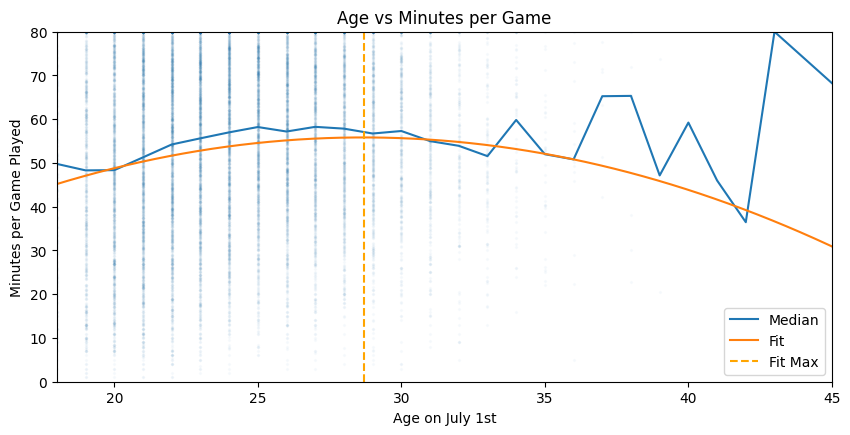

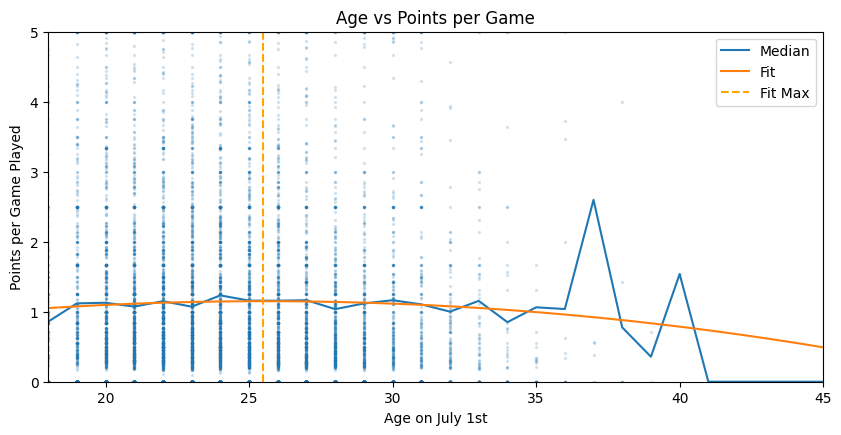

In [161]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.ylim([0,80])
plt.xlim([18,45])
plt.plot(players_df.groupby('age').median()['min_avg'])

#Fit data
X = np.array(players_df['age'])
y = np.array(players_df['min_avg'])
idx = np.isfinite(X) & np.isfinite(y)
fit = np.polyfit(X[idx],y[idx],2)
X_fit = np.arange(15, 50, .1)
y_fit = (X_fit**2)*fit[0] + X_fit*fit[1] + fit[2]

plt.plot(X_fit, y_fit)

plt.plot([X_fit[y_fit.argmax()], X_fit[y_fit.argmax()]], [0,80], linestyle = '--', c='orange')

plt.legend(['Median', 'Fit', 'Fit Max'])
plt.scatter(players_df['age'], players_df['min_avg'], alpha = .025, s=2)
plt.xlabel('Age on July 1st')
plt.ylabel('Minutes per Game Played')
plt.title('Age vs Minutes per Game')
plt.show()
age_peak = X_fit[y_fit.argmax()]

plt.figure(figsize=(10,10))
plt.subplot(2,1,2)
plt.ylim([0,5])
plt.plot(players_df.groupby('age').mean()['pts_avg'])

#Fit data
X = np.array(players_df['age'])
y = np.array(players_df['pts_avg'])
idx = np.isfinite(X) & np.isfinite(y)
fit = np.polyfit(X[idx],y[idx],2)
X_fit = np.arange(15, 50, .1)
y_fit = (X_fit**2)*fit[0] + X_fit*fit[1] + fit[2]

plt.plot(X_fit, y_fit)

plt.plot([X_fit[y_fit.argmax()], X_fit[y_fit.argmax()]], [0,10], linestyle = '--', c='orange')

plt.legend(['Median', 'Fit', 'Fit Max'])
plt.scatter(players_df['age'], players_df['pts_avg'], alpha = .15, s=2)
plt.xlabel('Age on July 1st')
plt.ylabel('Points per Game Played')
plt.title('Age vs Points per Game')
plt.xlim([18, 45])
plt.show()

While the majority of players are under the age of thirty. Minutes per game peak for players around 30. Unlike minutes, player points tend to peak at around 25 years old. It may seem odd that these numbers are not closer, but it is likely due to position. Most tries are scored by athletic backs for whom speed and athleticism are much more important.

## Model Minutes Data

A new dataset is needed with only the necessary data to model the minute data. This model will only use the current and previous competition, age, previous year minutes average, and career minutes average. This data proved to be the most predictive and fit well with the analysis this model is used for.

In [135]:
#Isolate necessary columns
columns = list(players_df.columns)
players_df = players_df[players_df['league_change']]
removals = ['player_id', 'birthdate', 'pos', 'year', 'team', 'pts', 'played', 'start', 'try', 'pen', 'dp', 'tr', 'yellow', 'red', 'min', 'prev_year_min', 'prev_year_played', 'min_avg', 'career_played', 'career_min', 'career_start', 'prev_year_start', 'league_change','career_start_avg',  'prev_year_start_avg', 'pts_avg']
for string in removals:
    columns.remove(string)
players_mod_df = players_df[columns]
players_mod_df.replace([np.inf, -np.inf], np.nan, inplace=True)
players_mod_df = players_mod_df.dropna(axis=0)

#Normalize  numerical data
player_mod_y = (players_df['min_avg'] > players_df['prev_year_min_avg'])
players_mod_df['age'] = players_mod_df['age']/52
players_mod_df['prev_year_min_avg'] = players_mod_df['prev_year_min_avg']/80
players_mod_df['career_min_avg'] = players_mod_df['career_min_avg']/80


/var/folders/7v/_90wc0ds3jd2h03mn95j4sfc0000gn/T/ipykernel_3767/3343878052.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_mod_df.replace([np.inf, -np.inf], np.nan, inplace=True)


In [136]:
#Import Modules
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier

This model is a classifier that predicts whether a player's minutes will increase in the current season. Because it is a classifier with a relatively small sample, I decided that a support vector classifier would be the most effective choice. The function param_opt uses GridSearchCV to find the best parameters for the model. The function test 1000 tests 1000 iterations of the model and gives the average test and training accuracy. This function also reports a baseline accuracy which assumes every player increases their minutes.

In [137]:
def param_opt(X, y, param_grid, model):
    param_grid_res = dict(param_grid)
    #Create dict to save params
    for key in param_grid_res.keys():
        param_grid_res[key] = []
    for i in range(100):
        #Iterate GridSearchCV with different splits and save each best params in a dataframe
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)
        grid = GridSearchCV(model, param_grid, refit = True, verbose = 0, n_jobs=8)
        grid.fit(X_train, y_train)
        for key, value in grid.best_params_.items():
            param_grid_res[key].append(value)
        if(i%10 == 0):
            print(i/100)
    return(pd.DataFrame.from_dict(param_grid_res))

In [138]:
def test_1000(X, y, model):
    test_acc = []
    train_acc = []
    baseline_acc = []
    for i in range(1000):    
        #Run the model 1000 times to find an precise model accuracy
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)
        mod = model
        mod.fit(X_train, y_train)
        train_pred = mod.predict(X_train)
        test_pred = mod.predict(X_test)
        test_acc.append(accuracy_score(y_test, test_pred))
        train_acc.append(accuracy_score(y_train, train_pred))
        baseline_acc.append(1-np.mean(y_test))
        if(i%100 == 0):
            print(i/1000)
    test_acc_mean = np.mean(np.array(test_acc))
    train_acc_mean = np.mean(np.array(train_acc))
    base_mean = np.mean(np.array(baseline_acc))
    test_base_mean = np.mean(np.array(test_acc)) - np.mean(np.array(baseline_acc))
    return(test_acc_mean, train_acc_mean, base_mean, test_base_mean)
#Function reports the test accuracy, training accuracy, baseline accuracy and the difference between the baseline accuracy and test accuracy


Below I run 100 instances of GridSearch CV and print the combinations with how often they occur.

In [148]:
X = np.array(players_mod_df)
y = np.where(player_mod_y, 1, 0)
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [ 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf', 'sigmoid', 'linear']}
svc_params = param_opt(X, y, param_grid, svm.SVC())
print(svc_params.groupby(svc_params.columns.tolist(), as_index = False).size())

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
       C   gamma   kernel  size
0      1  0.1000   linear     3
1     10  0.0100      rbf     1
2     10  0.1000   linear    14
3     10  0.1000  sigmoid     1
4    100  0.0100      rbf     7
5    100  0.0100  sigmoid     4
6    100  0.1000   linear    16
7    100  0.1000      rbf     1
8   1000  0.0001      rbf     1
9   1000  0.0010      rbf    10
10  1000  0.0010  sigmoid     2
11  1000  0.0100  sigmoid    29
12  1000  0.1000   linear    11


Next, I run the test_1000 function on the five most common combinations to see which one fits best for analysis. From this I found that the best parameters are C = 1000, gamma = .01, and kernel = 'sigmoid'. This model is accurate seventy-three percent of the time on test data and seventy-four percent on sample data. The baseline accuracy is fifty-two percent meaning the model outperforms the baseline by forty percent.

In [140]:
X = np.array(players_mod_df)
y = np.where(player_mod_y, 1, 0)
print(test_1000(X, y, svm.SVC(C = 1000, gamma = .1, kernel = 'linear')))
print(test_1000(X, y, svm.SVC(C = 1000, gamma = .01, kernel = 'sigmoid')))
print(test_1000(X, y, svm.SVC(C = 1000, gamma = .001, kernel = 'rbf')))
print(test_1000(X, y, svm.SVC(C = 100, gamma = .1, kernel = 'linear')))
print(test_1000(X, y, svm.SVC(C = 10, gamma = .1, kernel = 'linear')))


0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
(0.7307435897435899, 0.7396573426573426, 0.5212785547785548, 0.2094650349650351)
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
(0.7312272727272727, 0.7391843156843158, 0.5212004662004662, 0.2100268065268065)
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
(0.7293205128205128, 0.7391143856143856, 0.5206771561771562, 0.20864335664335665)
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
(0.7302937062937063, 0.7397682317682318, 0.5208496503496504, 0.2094440559440559)
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
(0.7308508158508159, 0.7392902097902097, 0.5208368298368298, 0.21001398601398613)


## Ranking League Strength with Model

I aimed to use this model to generate a general strength ranking of the nine leagues I tested. I do this by generating 500 samples of each combination of leagues and running them through the model. By finding the percentage of players expected to increase for each league, we can surmise that the leagues with the slightest increase are the strongest. To ensure accuracy, I ran the sampling and modeling 25 times. The samples are created by resampling, with replacement of the raw data to ensure that the distributions are similar to the original data. 

In [221]:
#Import Modules
from sklearn.utils import resample
from sklearn.utils import shuffle

In [222]:
def generate_sample(age, prev_year_min_avg, career_min_avg, competitions):
    #Generate resample of age, prev_year_min_avg, and career_min_avg
    career_min_avg_resample = shuffle(resample(career_min_avg, n_samples = 36000))
    prev_year_min_avg_resample = shuffle(resample(prev_year_min_avg, n_samples = 36000))
    age_resample = shuffle(resample(age, n_samples = 36000))
    
    random_players = np.empty(shape = (np.shape(competitions)[0]*4000, 5), dtype='object')

    #Fill array with every combination of prev and current leagues
    for i in range(len(competitions)):
        random_players[i*4000:(i+1)*4000, 3] = competitions[i]
        comp_temp = list(competitions)
        comp_temp.remove(competitions[i])
        for j in range(len(comp_temp)):
            random_players[(i*4000)+(j*500):((i+1)*4000) + ((j+1)*500), 4] = comp_temp[j]
    random_players[:,0] = age_resample
    random_players[:,1] = prev_year_min_avg_resample
    random_players[:,2] = career_min_avg_resample
    
    #Return data array and pandas dataframe
    index_values = np.arange(36000)
    column_names = ['age', 'prev_year_min_avg', 'career_min_avg', 'prev_year_competition', 'competition']
    random_players_df = pd.DataFrame(data = random_players, index = index_values, columns = column_names)
    random_players_dum_df = pd.get_dummies(random_players_df, columns = ['prev_year_competition', 'competition'])
    random_players_arr = np.array(random_players_dum_df)
    
    return(random_players_arr, random_players_df)

In [226]:
def run_random_data(random_players_arr, X, y, model):
    #Retrain the model on original data and predict minutes increas
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)
    model.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    random_players_pred = svc.predict(random_players_arr)
    return(random_players_pred)


In [238]:
#Run model and resample 25 times and save array with 25 columns. Collapse columns by finding mean
X = np.array(players_mod_df)
y = np.where(player_mod_y, 1, 0)
results = np.zeros((25,36000))
for i in range(25):
    arr, df = generate_sample(players_mod_df['age'], players_mod_df['prev_year_min_avg'], players_mod_df['career_min_avg'], total_competitions)
    results[i,:] = run_random_data(arr, X, y, svm.SVC(C = 1000, gamma = .01, kernel = 'sigmoid'))
random_players_pred = np.mean(results, 0)

In [239]:
#Find the mean for each ending competition
df['increase'] = random_players_pred
print(df.groupby('competition').mean())

                             increase
competition                          
Currie Cup                    0.45539
England Championship          0.56128
England Premiership           0.33957
NPC                           0.50435
National Rugby Championship   0.54157
Pro D2                        0.51007
Super Rugby                   0.34098
Top 14                        0.43901
United Rugby Championship     0.41916


| Competition                      | Pct. Increase in Minutes |
| :------------------------------- | :----------------------- |
| England Premiership              | 34.0%                    |
| Super Rugby                      | 34.1%                    |
| United Rugby Championship        | 41.9%                    |
| Top 14                           | 43.9%                    |
| Currie Cup                       | 45.5%                    |
| National Provincial Championship | 50.4%                    |
| Pro D2                           | 51.0%                    |
| National Rugby Championship      | 54.1%                    |
| England Championship             | 56.1%                    |

Because the model is not 100% accurate, minor differences here should not be considered conclusive. This does, however, show three distinct tiers of competition. These results are not inconsistent with general opinion about the international leagues. The England Premiership and Super Rugby are far and away the strongest leagues. URC, Top 14, and the Currie Cup are in the next tier of leagues, with the average player decreasing their minutes but not nearly to the level of the top two. The NPC, Pro D2, NRC, and England Championship increasing in minutes is not surprising considering their relationship with the other leagues. Pro D2 and England Championship are of the second tier in their respective nations, and most of the top players in the NRC and NPC feed into Super Rugby.